In [5]:
import numpy as np
import pickle as pkl

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import cmasher as cmr

import sys
sys.path.append("../functions/")

import preprocessing
import analysisplots
import experiment_settings
import build_model

# pretty plots
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.sans-serif']=['Verdana']

params = {"ytick.color": "k",
          "xtick.color": "k",
          "axes.labelcolor": "k",
          "axes.edgecolor": "k"}
plt.rcParams.update(params)

In [10]:
modelpath = "../models/"
experiment_name = "allcmodel-tos_allcmodel-tos_1-5yearlead"
experiment_dict = experiment_settings.get_experiment_settings(experiment_name)
filefront = experiment_dict["filename"]
filename = modelpath + experiment_dict["filename"]
modellist = experiment_dict["modellist"]
outbounds = experiment_dict["outbounds"]
trainvariants = experiment_dict["trainvariants"]
valvariants = experiment_dict["valvariants"]
testvariants = experiment_dict["testvariants"]
seedlist = experiment_dict["seeds"]
run = experiment_dict["run"]
leadtime = experiment_dict["leadtime"]
year1 = 1851+run

lon, lat = preprocessing.outlonxlat(experiment_dict)
lon = np.asarray(lon)
lat = np.asarray(lat)
centre = (outbounds[2]+outbounds[3])/2
projection = ccrs.EqualEarth(central_longitude=centre)
inres = experiment_dict["inres"]
transform = ccrs.PlateCarree()
obsyearvec = np.arange(1870+2*run+leadtime,2023,)
modelyearvec = np.arange(year1+2*run+leadtime,2015)

In [11]:
datafile = "../processed_data/" + filefront + ".npz"

datamat = np.load(datafile)

allinputdata = datamat["allinputdata"]
alloutputdata = datamat["alloutputdata"]

trainvaltest = [trainvariants,valvariants,testvariants]

inputdata,inputval,inputtest,outputdata,outputval,outputtest = preprocessing.splitandflatten(
    allinputdata,alloutputdata,trainvaltest,experiment_dict["run"])

inputdata[:, np.isnan(np.mean(inputdata, axis=0))] = 0
inputval[:, np.isnan(np.mean(inputval, axis=0))] = 0
inputtest[:, np.isnan(np.mean(inputtest, axis=0))] = 0

outputstd = np.std(outputdata, axis=0, keepdims=True)
outputdata = outputdata/outputstd
outputval = outputval/outputstd
outputtest = outputtest/outputstd

outputdata[:, np.isnan(np.mean(outputdata, axis=0))] = 0
outputval[:, np.isnan(np.mean(outputval, axis=0))] = 0
outputtest[:, np.isnan(np.mean(outputtest, axis=0))] = 0  

conversion done


In [12]:
for random_seed in seedlist[:1]:

    fileout = filename + "_seed=" + str(random_seed) +".h5"

    tf.random.set_seed(random_seed)
    np.random.seed(random_seed) 
    
    full_model = build_model.build_CNN_full(inputdata, outputdata, 
                                                    experiment_dict, random_seed)  
    
    full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),  # optimizer
                        loss=tf.keras.losses.MeanSquaredError(), 
                      )

    full_model.load_weights(fileout)
    
    full_model.trainable = False # freeze BN
    
    y_pred_test = full_model.predict(inputtest)
    y_pred_val = full_model.predict(inputval) 


336/336 [==============================] - 1s 4ms/step


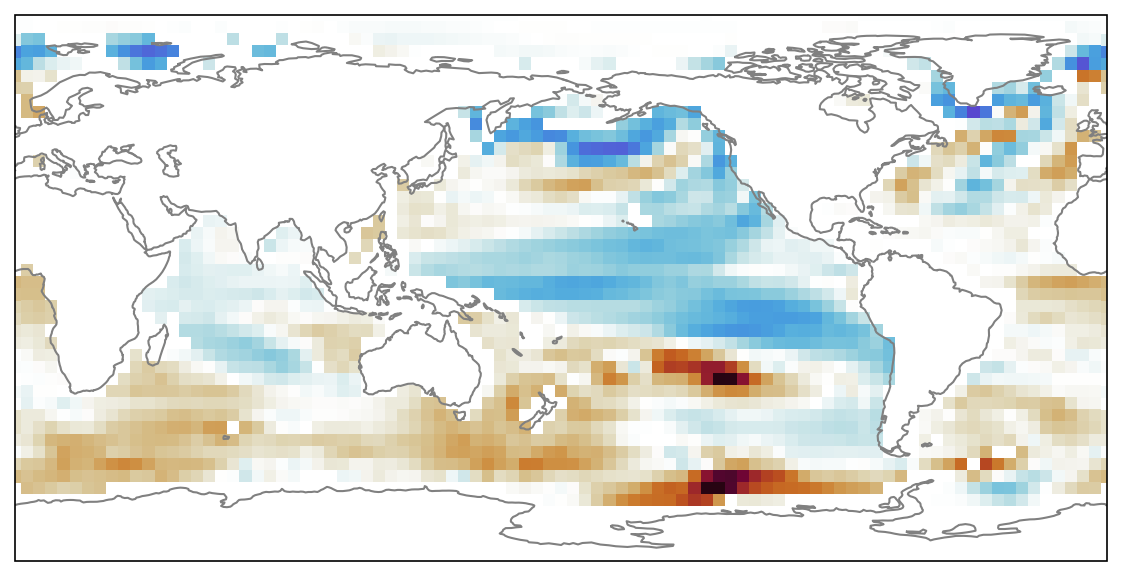

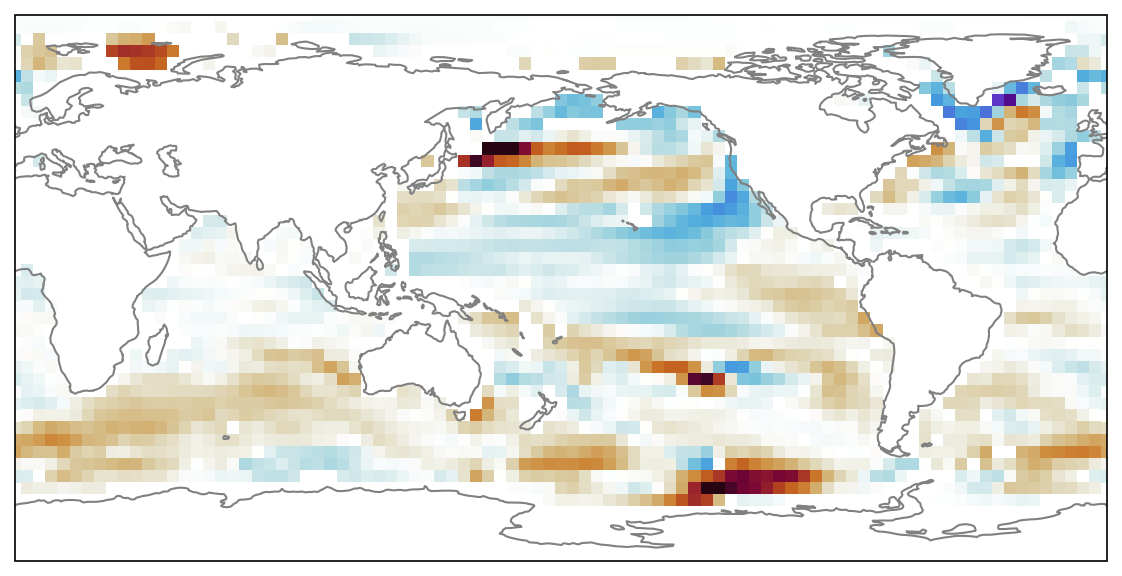

In [24]:
inlat = np.arange(-90+inres,90+inres,inres)
inlon = np.arange(0+inres,360+inres,inres)

plt.figure(figsize = (10,4))

a=plt.subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=180))
a.pcolormesh(inlon,inlat,inputval[0,:,:,0],vmin=-1.5,vmax=1.5,cmap=cmr.fusion_r,transform=ccrs.PlateCarree())
a.coastlines(color='gray')

plt.tight_layout()
plt.show()

plt.figure(figsize = (10,4))

a=plt.subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=180))
a.pcolormesh(inlon,inlat,inputval[0,:,:,1],vmin=-1.5,vmax=1.5,cmap=cmr.fusion_r,transform=ccrs.PlateCarree())
a.coastlines(color='gray')

plt.tight_layout()
plt.show()

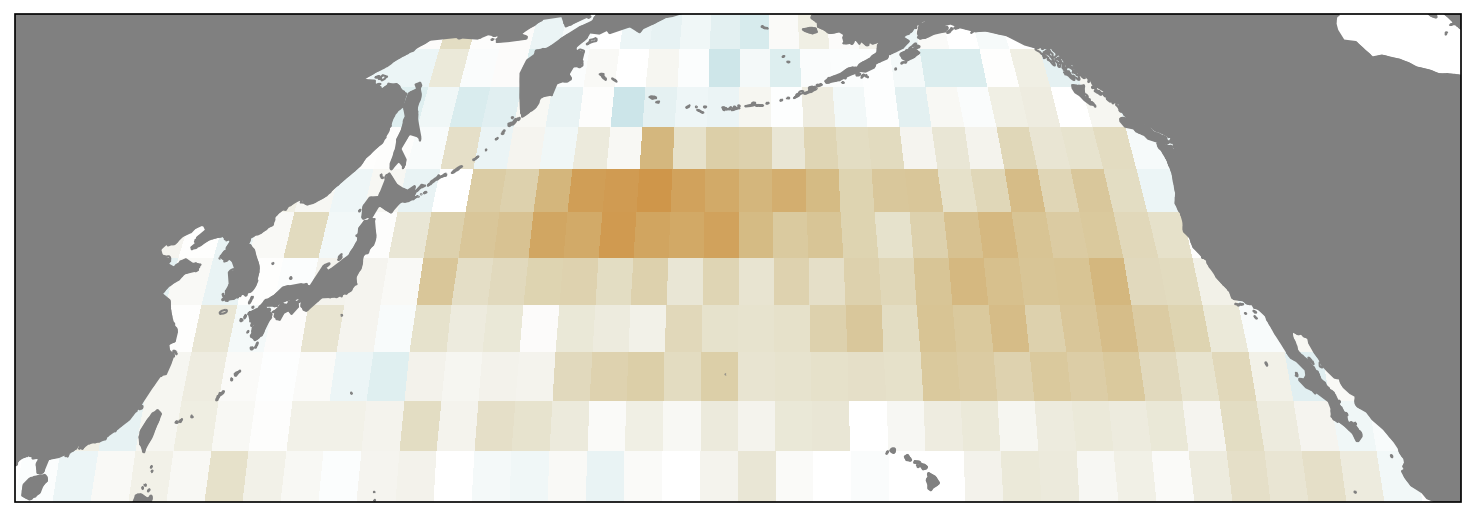

In [27]:
plt.figure(figsize = (10,4))

a=plt.subplot(1,1,1,projection=projection)
a.pcolormesh(lon,lat,y_pred_val[0,:,:],vmin=-3,vmax=3,cmap=cmr.fusion_r,transform=ccrs.PlateCarree())
a.coastlines(color='gray')
a.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor="gray"))

plt.tight_layout()
plt.show()